<a href="https://colab.research.google.com/github/vijayakuruba/IFT6390_Classification_of_AMP_sequences/blob/main/IFT_6390_Final_Project_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6390: Final Project

The final project pertains to the problem of finding novel [antimicrobial peptides](https://en.wikipedia.org/wiki/Antimicrobial_peptides) (AMP) which may turn out to be key in the fight against antibiotics resistance. The World Health Organization qualifies antibiotic resistance as one of the [''biggest threats to global health, food security, and development today''](https://www.who.int/news-room/fact-sheets/detail/antibiotic-resistance).

Given the limited time frame of this project, I have scoped down the problems to two main tracks:

1. **Classification**: classifying protein sequences as AMP or non-AMP: a binary classification problem
  1.1 You are allowed to use Scikit-learn. You need to provide the following baselines: Random Forest, SVM, Neural Network. Use TF-IDF as a baseline feature extractor (you can use sklearn) for each of those.  
2. **Generation**: Given a corpus of AMP sequences, learn a character-level language model. You should implement a baseline using a Markov model. Then implement a sequential model using an RNN or LSTM. 

You should pick one of the two options. Choose your own adventure. You can work in teams of **three people max**.

# Dataset

The dataset in this project comes from two open source projects: amPEPpy and AMPlify.

In [1]:
!pip install biopython
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_AMP_sequence.numbered.fasta
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_nonAMP_sequence.numbered.fasta

     |████████████████████████████████| 2.3MB 13.9MB/s 
--2021-04-29 14:25:22--  https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166037 (162K) [text/plain]
Saving to: ‘AMP_20190407.fa’

AMP_20190407.fa     100%[===================>] 162.15K  --.-KB/s    in 0.01s   

2021-04-29 14:25:22 (15.6 MB/s) - ‘AMP_20190407.fa’ saved [166037/166037]

--2021-04-29 14:25:22--  https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, a

In [2]:
from Bio import SeqIO
import matplotlib.pyplot as plt

In [3]:
def fasta_to_str_set(name):
  return {str(rec.seq) for rec in SeqIO.parse(name, 'fasta')}

In [4]:
positive_examples = fasta_to_str_set('AMP_20190407.fa').union(fasta_to_str_set('M_model_train_AMP_sequence.numbered.fasta'))
negative_examples = fasta_to_str_set('non_AMP_20190413.fa').union(fasta_to_str_set('M_model_train_nonAMP_sequence.numbered.fasta'))

Once we have merged the two data sources, the positive class has:

In [5]:
print(f"{len(positive_examples)} examples")

5264 examples


and the negative class (non-AMPs) has:

In [6]:
print(f"{len(negative_examples)} examples")

167732 examples


Let's have a look at the data. For example, the first AMP and Non AMP in the dataset is:

In [7]:
print('First AMP sample is : ',list(positive_examples)[0])
print('First Non AMP sample is :',list(negative_examples)[0])

First AMP sample is :  FLSLIPHAINAVSALAKHF
First Non AMP sample is : MHTVKLLCVVFSCLCAVAWGSSHVSNRQPCHSPQLTSGTMKVISTGGHDLASGEFNYDSKANKFRFVEDTTHANKTSYMDVLVHFEEGVLYEIDSKNESCKKETLQFRKHLMEIPPDATHESEIYMGSPSITEQGLRVRVWNGKLPELHAHYSLSTTSCGCLPVSGSYYGEKKDLFFSFFGVETEVDDPQVFVPPAYCEGVSFEEAPDDHSFFDLFHD


We have 2 challenges here:
1. Imbalanced dataset: No of non-AMPs are more way higher than AMP. 
2. the distribution of the sequence lengths varies a lot between the two classes. 

## Exploratory data Analysis

Text(0.5, 1.0, 'Negative Sequence Lengths')

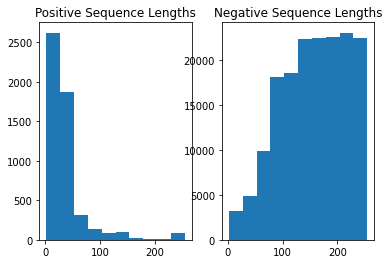

In [8]:
# Visualise samples

#Original dataset

fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples])
axes[1].set_title('Negative Sequence Lengths')

## Feature importance
Lets see which Amino acid is more important. We have used TFIDI Tokenizor to count the raw frequencies and plotted the features which are more frequent or Important

In [41]:
#TFIDI Tokenizor: This function will be used downstream
from sklearn.feature_extraction.text import TfidfVectorizer
def dummy(doc):
    return doc
tfidf = TfidfVectorizer(tokenizer=dummy,preprocessor=dummy,lowercase=False)  

In [24]:
# create Datarame with original dataset

# Dataframe with original data

import pandas as pd 
df_orig_p=pd.DataFrame(positive_examples,columns=['Sequences'])
df_orig_p['Labels']=1
df_orig_p['SqLen'] = np.array([len(seq) for seq in positive_examples])
df_orig_n=pd.DataFrame(negative_examples,columns=['Sequences'])
df_orig_n['Labels']=0
df_orig_n['SqLen'] = np.array([len(seq) for seq in negative_examples])

df=pd.DataFrame()
df=df.append(df_orig_p,ignore_index=True)
df=df.append(df_orig_n,ignore_index=True)
print(df.shape)
df

(172996, 3)


,Sequences,Labels,SqLen
0,FLSLIPHAINAVSALAKHF,1,19
1,RRWWRF,1,6
2,APIIRRIPYYPEVESDLRIVDCKRSEGFCQEYCNYLETQVGYCSKK...,1,53
3,KFKKLFKKLSPVIGKEFKRIVERIKRFLR,1,29
4,FLFPLITSFLSKVL,1,14
...,...,...,...
172991,MKNFIFNHPLISDKLSKMRDVNTGYNFFKQLLTEITTLMMYEVGKG...,0,210
172992,MKVKPSVKKICDKCKVIRRHGRVMIICENLRHKQRQG,0,37
172993,MLTKAEALAHTVIYRKNSRFDKVKEKSEELTLIGKGRSAYVFALTE...,0,215
172994,MGKLTLLLLAILVWLQYSLWFGKNGIHDYTRVNDDVAAQQATNAKL...,0,103


This string describes the sequence of amino acids present in the given AMP. There are  20  possible such standard amino acids present in the genetic code. 
We can see from the plot below that the most frequent amino acid code is Leucine(L) followed by Alanine(A), Valine(V) and Glycine(G).

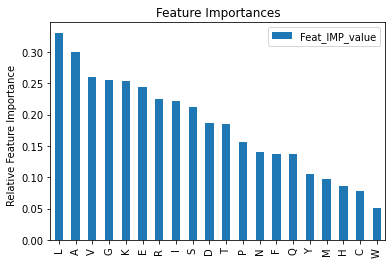

In [14]:
#TfidfVectorizer

import numpy as np

X=df['Sequences']

X_transform = tfidf.fit_transform(X)
word = tfidf.get_feature_names()

TFIDF_mean = np.mean(X_transform, axis=0)

TFIDF_mean = np.array(TFIDF_mean)[0].tolist()

# Feature_importance=top_feats(TFIDF_mean ,Word, Imp_Feat)

topn_ids = np.argsort(TFIDF_mean)[::-1][:1000]
names = np.array(word)
# print(names[topn_ids])
top_feats = [(word[i], TFIDF_mean[i]) for i in topn_ids]
df_feat = pd.DataFrame(top_feats, index=names[topn_ids])
df_feat.columns = ['FEATURE', 'Feat_IMP_value']

Feature_importance = df_feat
df_feat[:30].plot.bar(y='Feat_IMP_value', title='Feature Importances', rot=90)
plt.ylabel('Relative Feature Importance  ')
New_FI_index = Feature_importance.reset_index()
del New_FI_index['index']
plt.show()
#plt.savefig('feature_Importance.png')

#Construct Dataset

## Dataset 1 : Construct Non AMP Dataset by ignoring Non AMP samples length not in AMP sequence.

To addres the issue of the the distribution of the sequence lengths  between the two classes, I have reconstructed non AMP dats such that, I have included only the sequences whose legths are present in AMP sequence. For example samples whose sequence length is 145 is discared since this length is not present in AMP sequence. 
After this , Non AMP samples are reduced to 109344. 

Even after this still we have imbalanced dataset issue which will be addressed with Oversampling and Undersampling techniques.

First construct Non AMP samples:

In [15]:
import numpy as np

lenp=[]
for seq in positive_examples:
    lenp.append(len(seq))
ulenp=np.unique(lenp)
print(ulenp)

[  2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 133 134 135 136 137 138 140 141 142 143 146 148 149 150 152 153 154
 155 157 158 161 163 164 166 169 172 174 177 183 185 187 188 190 191 192
 194 198 200 201 204 206 207 208 215 219 220 221 222 225 226 230 231 235
 239 241 243 244 245 247 255]


In [16]:
lenn=[]
for seq in negative_examples:
    lenn.append(len(seq))
print(np.unique(lenn))

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 24

In [17]:
negative_examples_new=[]
for i in ulenp:
    for seq in negative_examples: 
        if len(seq)==i:
           negative_examples_new.append(seq)

print(len(negative_examples_new))

109344


Lets visualise the samples after reconstructing the negative samples
Still we have imbalanced data issue

Text(0.5, 1.0, 'Negative Sequence Lengths')

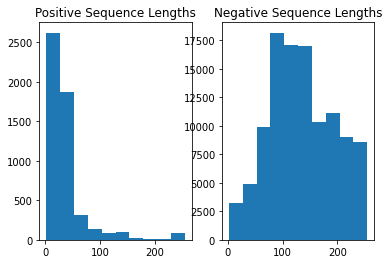

In [28]:
# after removing sequences in Non AMP whose length is not in postivie sample 

fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples_new])
axes[1].set_title('Negative Sequence Lengths')

In [29]:
df_recon_n=pd.DataFrame(negative_examples_new,columns=['Sequences'])
df_recon_n['Labels']=0
df_recon_n['SqLen'] = np.array([len(seq) for seq in negative_examples_new])

In [30]:
print('positive_examples shape is:', df_orig_p.shape)
print('Original negative_examples shape is:', df_orig_n.shape)
print('Reconstructed negative_examples shape is:', df_recon_n.shape)

positive_examples shape is: (5264, 3)
Original negative_examples shape is: (167732, 3)
Reconstructed negative_examples shape is: (109344, 3)


In [31]:
# dataframe with new datset
df_new=pd.DataFrame()
df_new=df_new.append(df_orig_p,ignore_index=True)
df_new=df_new.append(df_recon_n,ignore_index=True)
print(df_new.shape)
df_new

(114608, 3)


,Sequences,Labels,SqLen
0,FLSLIPHAINAVSALAKHF,1,19
1,RRWWRF,1,6
2,APIIRRIPYYPEVESDLRIVDCKRSEGFCQEYCNYLETQVGYCSKK...,1,53
3,KFKKLFKKLSPVIGKEFKRIVERIKRFLR,1,29
4,FLFPLITSFLSKVL,1,14
...,...,...,...
114603,MVFDTHLHTLFSTDSKMNIEEAIDAGEKKNLGIIITEHIDLNYPVK...,0,255
114604,MRHPLVMGNWKLNGSKHMVNDLTAALRNELSSVVGCDVAIAPPVTY...,0,255
114605,MSKAFLPTILEQKGKEVSQLVMEDLQPLRQTYRLYDFLKSNQNKLQ...,0,255
114606,MMTAEVRTPEQGGGPLTTEPRAPRSAPGHADASAPAFGPETDPRDI...,0,255


##Dataset 2 : Construct AMP and Non AMP Dataset whose length <125

As we can see from the below box plot, for AMP samples, 95 percentile sequence length is 125. Hence I reconstructed both AMP and Non AMP sequences whose length is below 125.

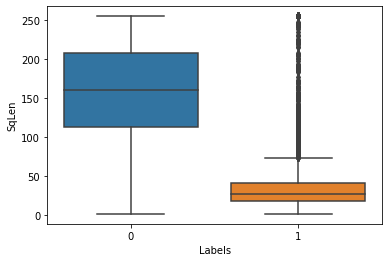

In [325]:
import seaborn as sns
sns.boxplot(data=df,x=df['Labels'],y=df['SqLen'])

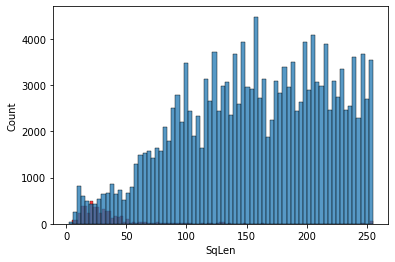

In [326]:
sns.histplot(df_orig_p['SqLen'],color='red')
sns.histplot(df_orig_n['SqLen'])

In [327]:
print("5th percentile of Positive sample is:",np.percentile(df_orig_p['SqLen'], 5)) 
print("95th percentile of Positive sample is:",np.percentile(df_orig_p['SqLen'], 95) )

print("5th percentile of Negative sample is:",np.percentile(df_orig_n['SqLen'], 5)) 
print("95th percentile of Negative sample is:",np.percentile(df_orig_n['SqLen'], 95) )

5th percentile of Positive sample is: 11.0
95th percentile of Positive sample is: 125.0
5th percentile of Negative sample is: 54.0
95th percentile of Negative sample is: 246.0


In [307]:
df_pos_2=df_orig_p[df_orig_p['SqLen'] <125]
df_neg_2=df_orig_n[df_orig_n['SqLen'] <125]

df_pos_2=df_pos_2.reset_index(drop=True)
df_neg_2=df_neg_2.reset_index(drop=True)

In [308]:
print('positive_examples shape is:', df_pos_2.shape)
print('Reconstructed negative_examples shape is:', df_neg_2.shape)

positive_examples shape is: (4998, 3)
Reconstructed negative_examples shape is: (51552, 3)


In [312]:
# dataframe with new datset
df_new_2=pd.DataFrame()
df_new_2=df_new_2.append(df_pos_2,ignore_index=True)
df_new_2=df_new_2.append(df_neg_2,ignore_index=True)
print(df_new_2.shape)
df_new_2


(56550, 3)


,Sequences,Labels,SqLen
0,FLSLIPHAINAVSALAKHF,1,19
1,RRWWRF,1,6
2,APIIRRIPYYPEVESDLRIVDCKRSEGFCQEYCNYLETQVGYCSKK...,1,53
3,KFKKLFKKLSPVIGKEFKRIVERIKRFLR,1,29
4,FLFPLITSFLSKVL,1,14
...,...,...,...
56545,MMLEHVLVLSAYLFSIGIYGLITSRNLVRALMCLELILNAVNLNFV...,0,101
56546,MPKMKTDRGVAKRFKKTANGFKRKQAHLRHILTKKSTKRKRHLRAK...,0,64
56547,MANHKSAEKRARQTIKRTERNRFYRTRLKNITKAVREAVEAKDVNT...,0,89
56548,MKVKPSVKKICDKCKVIRRHGRVMIICENLRHKQRQG,0,37


Text(0.5, 1.0, 'Negative Sequence Lengths')

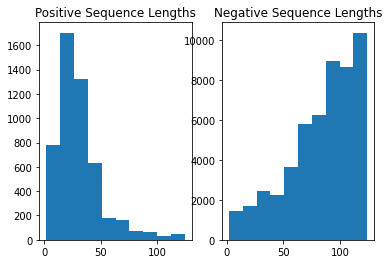

In [313]:
fig, axes = plt.subplots(1,2)
axes[0].hist(df_pos_2['SqLen'])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist(df_neg_2['SqLen'])
axes[1].set_title('Negative Sequence Lengths')

##Dataset 3 : Considering only one dataset

As seen from the below plots and dataset from Amplify is balanced and It has seq lengths balanced. Hence We tried using only Amplify  dataset on Neural network model.

In [328]:
positive_examples_3 = fasta_to_str_set('AMP_20190407.fa')
negative_examples_3 = fasta_to_str_set('non_AMP_20190413.fa')

In [330]:
print(f"{len(positive_examples_3)} examples")
print(f"{len(negative_examples_3)} examples")

4173 examples
4173 examples


Text(0.5, 1.0, 'Negative Sequence Lengths')

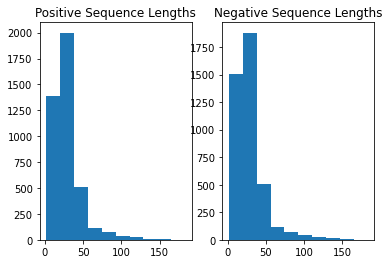

In [333]:
# after removing sequences in Non AMP whose length is not in postivie sample 

fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples_3])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples_3])
axes[1].set_title('Negative Sequence Lengths')

In [331]:
positive_examples_4 = fasta_to_str_set('M_model_train_AMP_sequence.numbered.fasta')
negative_examples_4 = fasta_to_str_set('M_model_train_nonAMP_sequence.numbered.fasta')

In [332]:
print(f"{len(positive_examples_4)} examples")
print(f"{len(negative_examples_4)} examples")

3268 examples
166791 examples


Text(0.5, 1.0, 'Negative Sequence Lengths')

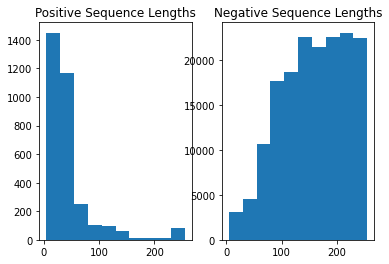

In [334]:
# after removing sequences in Non AMP whose length is not in postivie sample 

fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples_4])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples_4])
axes[1].set_title('Negative Sequence Lengths')

In [336]:
df_p3=pd.DataFrame(positive_examples_3,columns=['Sequences'])
df_p3['Labels']=1
df_p3['SqLen'] = np.array([len(seq) for seq in positive_examples_3])
df_n3=pd.DataFrame(negative_examples_3,columns=['Sequences'])
df_n3['Labels']=0
df_n3['SqLen'] = np.array([len(seq) for seq in negative_examples_3])

df3=pd.DataFrame()
df3=df3.append(df_p3,ignore_index=True)
df3=df3.append(df_n3,ignore_index=True)
print(df3.shape)
df3

(8346, 3)


,Sequences,Labels,SqLen
0,FLSLIPHAINAVSALAKHF,1,19
1,RRWWRF,1,6
2,GLWQFIKDKLKDAATGLVTGIQS,1,23
3,FLKGVINLASKIPSMLCAVLKTC,1,23
4,GILDTIKNAAKTVAVGLLEKIKCKMTGC,1,28
...,...,...,...
8341,MIYRKWSLLSGPPVILGGAVIAAVAVGFVLQNVTKGEQKKNVSTNK,0,46
8342,IMYDCCSGSCSGYTGRC,0,17
8343,YPPKPENPGDDAAPEELAKYYSALRHYINLITRQRY,0,36
8344,METATLIAISISGLIVSFTGYALYTAFGQPSQQLRDPFEEHGD,0,43


#Data Preprocessing

Issue of Imbalance data is addressed with Oversampling and undersample techniques.
For Oversampling, we used ADASYN algorithm and for Undersampling is done by Randomunder sampling using imblearn modules. More details are in included the the analysis section.

#Tokenize Charecters

Tokenize the sequence in to chanrecters

In [35]:
# pre processing data
def cleanData(sentence):
    processedList = ""
    
# Tokenize sequence to charecters
    sentence=list(sentence)
  
    return sentence

In [39]:

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix,roc_auc_score,f1_score
from sklearn.svm import SVC


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

#Intitialisation

In [ ]:
# Havent used yet
result = pd.DataFrame(columns = ("classifers","Training","Testing"))
classifier, train_scores, test_scores = [],[],[]

#Cross validation 

Model accuracy is validated Cross validation, where In general practice Kfold=5 is widely used.

In [60]:
#Cross validation with K fold=5
k_fold = KFold(n_splits=5, shuffle=True,random_state=1)

#Baselines

Tree-based methods partition the feature space into a set of rectangles, and then fit a simple model (like a constant) in each one. They are conceptually simple yet powerful.
For classification problem, 

In a node m, representing a region $R_m$ with $N_m$ observations,
$$p_{mk} = 1/ N_m \sum_{y \in R_m} I(y = k)$$

the proportion of class k observations in node $m$.\
 We classify the observations in node $m$ to class $k(m)$ = $arg max_k p_{mk}$, the majority class in node $m$.

Different measures $R_m(T)$ of node impurity include the following:

Gini Index: 
$$H(R_m) = \sum_k p_{mk} (1 - p_{mk})$$

Cross Entropy: 
$$H(R_m) = - \sum_k p_{mk} \log(p_{mk})$$

Misclassification error:

$$H(Q_m) = 1 - \max(p_{mk})$$

**Random Forest :**  Random forests (Breiman, 2001) is a substantial modification of bagging that builds a large collection of de-correlated trees, and then averages them. Random Forest = Bagging of trees+Random feature selection 

1. Each decision tree is trained using a slightly different version of the training set, using both by

*   Bootstrapping (random selection of examples, withreplacement)
*   Randomly selecting a subset of features (reduce the inputdimension)

2.	The capacity of each tree (i.e. depth) is chosen using cross validation.

3.	The final prediction is a majority vote, like in Bagging

Algorithim:
1. For b = 1 to B:\
(a) Draw a bootstrap sample Z∗ of size N from the training data.\
(b) Grow a random-forest tree ${T_b}$ to the bootstrapped data, by recursively repeating the following steps for each terminal node of
the tree, until the minimum node size ${n_{min}}$ is reached.\
i. Select m variables at random from the p variables.\
ii. Pick the best variable/split-point among the m.\
iii. Split the node into two daughter nodes.
2. Output the ensemble of trees {${T_b}^B_1$} .\
To make a prediction at a new point x:\
Classification: Let $C_b(x)$ be the class prediction of the bth random-forest
tree. Then $C^B_{rf} (x) = majority vote$ $[{C^b(x)}]^B_1$  .



##Random Forest Classifier with SMOTE  & ADASYN Oversampling Technique


The purpose of the ADASYN algorithm is to improve class balance by synthetically creating new examples from the minority class via linear interpolation between existing minority class examples. This approach by itself is known as the SMOTE method (Synthetic Minority Oversampling TEchnique). ADASYN is an extension of SMOTE, creating more examples in the vicinity of the boundary between the two classes than in the interior of the minority class.



##Option 1 : Using dataset1

In [37]:
# tokenize charecters
df_new['Sequences']  = df_new['Sequences'] .map(lambda x: cleanData(x))
df_new

,Sequences,Labels,SqLen
0,"[F, L, S, L, I, P, H, A, I, N, A, V, S, A, L, ...",1,19
1,"[R, R, W, W, R, F]",1,6
2,"[A, P, I, I, R, R, I, P, Y, Y, P, E, V, E, S, ...",1,53
3,"[K, F, K, K, L, F, K, K, L, S, P, V, I, G, K, ...",1,29
4,"[F, L, F, P, L, I, T, S, F, L, S, K, V, L]",1,14
...,...,...,...
114603,"[M, V, F, D, T, H, L, H, T, L, F, S, T, D, S, ...",0,255
114604,"[M, R, H, P, L, V, M, G, N, W, K, L, N, G, S, ...",0,255
114605,"[M, S, K, A, F, L, P, T, I, L, E, Q, K, G, K, ...",0,255
114606,"[M, M, T, A, E, V, R, T, P, E, Q, G, G, G, P, ...",0,255


In [76]:
X=df_new['Sequences'] 
y=df_new['Labels'] 


X_train, X_test, y_train, y_test = train_test_split(X, y,
    stratify=y, 
    test_size=0.2, shuffle=True)


In [77]:
X_train_transform = tfidf.fit_transform(X_train)

In [78]:
rfs = RandomForestClassifier()

In [79]:
# Imbalance data with SMOTE
from imblearn.over_sampling import ADASYN

sm =  ADASYN(sampling_strategy='minority',random_state=1)
X_ada, y_ada = sm.fit_sample(X_train_transform , y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [81]:
from collections import Counter

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_ada)))

Original dataset shape Counter({0: 87475, 1: 4211})
Resampled dataset shape Counter({0: 87475, 1: 87031})


In [82]:
X_test = tfidf.transform(X_test)

rfs.fit(X_ada, y_ada)
y_pred = rfs.predict(X_test)


In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     21869
           1       0.62      0.76      0.68      1053

    accuracy                           0.97     22922
   macro avg       0.80      0.87      0.83     22922
weighted avg       0.97      0.97      0.97     22922



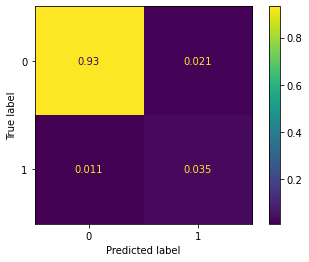

In [84]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfs, X_test, y_test, normalize='all')  
plt.show()

We can use the validation_curve to inspect the impact of varying the parameter k_neighbors. In this case, we need to use a score to evaluate the generalization score during the cross-validation.

##Option 2 : Using dataset2

In [314]:
df_new_2['Sequences']  = df_new_2['Sequences'] .map(lambda x: cleanData(x))
X=df_new_2['Sequences'] 
y=df_new_2['Labels'] 


X_train, X_test, y_train, y_test = train_test_split(X, y,
    stratify=y, 
    test_size=0.2, shuffle=True)

X_train_transform = tfidf.fit_transform(X_train)

X_ada, y_ada = sm.fit_sample(X_train_transform , y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_ada)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0: 41242, 1: 3998})
Resampled dataset shape Counter({0: 41242, 1: 41178})


In [315]:
X_test = tfidf.transform(X_test)

rfs.fit(X_ada, y_ada)
y_pred = rfs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10310
           1       0.66      0.77      0.71      1000

    accuracy                           0.94     11310
   macro avg       0.82      0.86      0.84     11310
weighted avg       0.95      0.94      0.95     11310



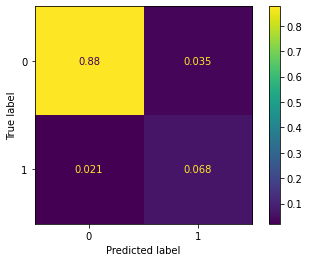

In [316]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfs, X_test, y_test, normalize='all')  
plt.show()

We can use the validation_curve to inspect the impact of varying the parameter maximum tree depth. In this case, we use f1 score to evaluate the generalization score during the cross-validation with K fold=5

In [317]:
from imblearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import validation_curve

model1 = Pipeline([('tfidf', tfidf),('adasyn',sm),('model',rfs)])


scorer = make_scorer(f1_score)
param_range = range(1, 11)
train_scores, test_scores = validation_curve(
    model1,
    X_train,
    y_train,
    param_name="adasyn__n_neighbors", 
    param_range=param_range,
    cv=k_fold,
    scoring=scorer,
)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [319]:
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)


[0.70637478 0.71021657 0.70845994 0.70860379 0.70899102 0.70449878
 0.70273974 0.6986247  0.69934782 0.70155592]


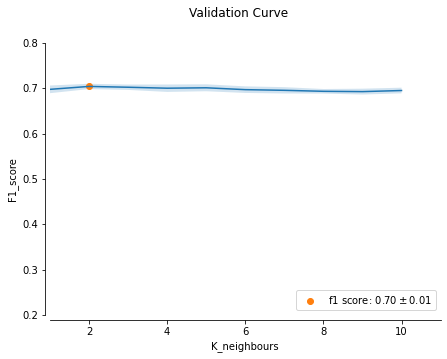

In [323]:
import matplotlib.pyplot as plt
import pandas


fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(param_range, test_scores_mean)

upr=np.minimum(test_scores_mean + test_scores_std,1)
print(upr)
lwr=np.maximum(test_scores_mean - test_scores_std,0)

ax.fill_between(
    param_range,
     upr,lwr,alpha=.2
)


idx_max = test_scores_mean.argmax()
ax.scatter(
    param_range[idx_max],
    test_scores_mean[idx_max],
    label=r"f1 score: ${:.2f}\pm{:.2f}$".format(
        test_scores_mean[idx_max], test_scores_std[idx_max]
    ),
)

fig.suptitle("Validation Curve")
ax.set_xlabel("K_neighbours")
ax.set_ylabel("F1_score")

# make nice plotting
sns.despine(ax=ax, offset=5)
ax.set_xlim([1, 11])
ax.set_ylim([0.2, 0.8])
ax.legend(loc="lower right")

plt.show()

##Random Forest Classifier with Undersampling data : Random Undersampler

RandomUnderSampler is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes.
For this Techniques, we used dataset1.

In [103]:
X=df_new['Sequences'] 
y=df_new['Labels'] 


X_train, X_test, y_train, y_test = train_test_split(X, y,
    stratify=y, 
    test_size=0.2, shuffle=True)


In [105]:
X_train_transform = tfidf.fit_transform(X_train)

In [106]:
# Imbalance data with SMOTE
from imblearn.under_sampling import RandomUnderSampler

rus=RandomUnderSampler(sampling_strategy='majority',random_state=1)
X_rs, y_rs = rus.fit_sample(X_train_transform , y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [108]:
from collections import Counter

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_rs)))

Original dataset shape Counter({0: 87475, 1: 4211})
Resampled dataset shape Counter({0: 4211, 1: 4211})


In [109]:
X_test = tfidf.transform(X_test)

rfs.fit(X_rs, y_rs)
y_pred = rfs.predict(X_test)

In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     21869
           1       0.39      0.93      0.55      1053

    accuracy                           0.93     22922
   macro avg       0.69      0.93      0.76     22922
weighted avg       0.97      0.93      0.94     22922



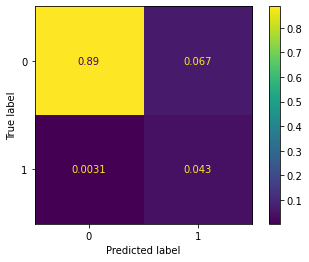

In [111]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfs, X_test, y_test, normalize='all')  
plt.show()

Model is validated with Kfold=5 crossvalidation with different tree depth parameters.

In [112]:
from imblearn.pipeline import Pipeline

model1 = Pipeline([('tfidf', tfidf),('rus',rus),('model',rfs)])

parameters = {
  'model__max_depth': [None,10,20,50,100],
  }


grid = GridSearchCV(model1, cv=k_fold, n_jobs=-1, param_grid=parameters)
grid.fit(X_train, y_train)
print('finished')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


finished


In [113]:
print("Best parameters set found on development set:")
print()
print(grid.best_params_)

Best parameters set found on development set:

{'model__max_depth': 10}


In [114]:
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:

0.927 (+/-0.006) for {'model__max_depth': None}
0.927 (+/-0.006) for {'model__max_depth': 10}
0.926 (+/-0.006) for {'model__max_depth': 20}
0.926 (+/-0.005) for {'model__max_depth': 50}
0.927 (+/-0.006) for {'model__max_depth': 100}


In [115]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import validation_curve

scorer = make_scorer(f1_score)
parameters = {
  'model__max_depth': [None,10,20,50,100],
  }
param_range = [None,10,20,50,100]
train_scores, test_scores = validation_curve(
    model1,
    X_train,
    y_train,
    param_name="model__max_depth", 
    param_range=param_range,
    cv=k_fold,
    scoring=scorer,
)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [234]:
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)



In [235]:
test_scores_mean

array([0.54176697, 0.54392278, 0.53928858, 0.53866424, 0.54090436])

In [224]:
param_range=np.array(param_range,dtype='float64')
param_range=np.nan_to_num(param_range,np.nan)

In [223]:
param_range

array([  0.,  10.,  20.,  50., 100.])

[0.56476212 0.56337603 0.5628335  0.5607688  0.56445195]


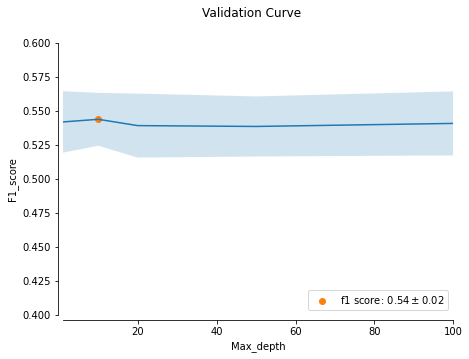

In [238]:
import matplotlib.pyplot as plt
import pandas


fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(param_range, test_scores_mean)

upr=np.minimum(test_scores_mean + test_scores_std,1)
print(upr)
lwr=np.maximum(test_scores_mean - test_scores_std,0)

ax.fill_between(
    param_range,
     upr,lwr,alpha=.2
)


idx_max = test_scores_mean.argmax()
ax.scatter(
    param_range[idx_max],
    test_scores_mean[idx_max],
    label=r"f1 score: ${:.2f}\pm{:.2f}$".format(
        test_scores_mean[idx_max], test_scores_std[idx_max]
    ),
)

fig.suptitle("Validation Curve")
ax.set_xlabel("Max_depth")
ax.set_ylabel("F1_score")

# make nice plotting
sns.despine(ax=ax, offset=5)
ax.set_xlim([1, 100])
ax.set_ylim([0.4, 0.6])
ax.legend(loc="lower right")

plt.show()

##SVM classifier

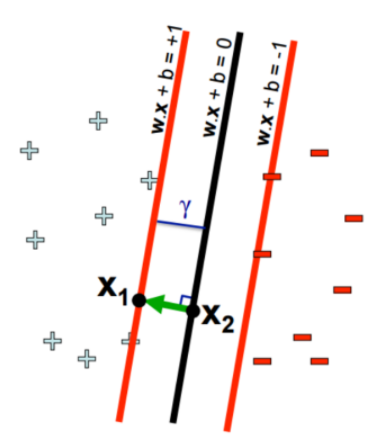

SVM algorithm learns a simple linear discriminant function g(x) =(w, x)+ b

• Finds a hyperplane, with geometric motivation of aim for maximum margin.

• It is very popular method in its lienar and Nonlinear form. Nonlinear version uses the kernel trick.

Linear Model:
\begin{equation}
 f(x) = \mathbf{w}^T \mathbf{x} + b   
\end{equation}
On Hyper plane :
\begin{equation}
f(x) =\mathbf{w}^T \mathbf{x} + b=0    
\end{equation}
Constraints are:
\begin{equation}
 \mathbf{w}^T \mathbf{x_i} + b\geq 1 \quad \text{if} \quad y_i=1 
 \end{equation}
\begin{equation}
 \mathbf{w}^T \mathbf{x_i} + b\leq -1 \quad \text{if} \quad y_i=-1   
\end{equation}

In general 
\begin{equation}
    y_i(\mathbf{w}^T \mathbf{x_i} + b)\geq 1 \quad \forall \quad i \in 1...N 
\end{equation}

Let $x_1$ be the point on boundary and $x_2$ be  the projection on hyperplane
\begin{equation}
     \mathbf{x_1-x_2} =\gamma  \frac{\mathbf{w}}{\| \mathbf{w}\|} 
\end{equation}

$\gamma  = \frac{1}{\| \mathbf{w}\|} $ Maximising margin is nothing but minimising the norm.\

**SVM with hardmargin : ***

 $$Hinge loss =  \sum_{i=1}\max(0, y_i (\mathbf{w^T} \mathbf{x_i} + b))$$

Hence, the objective function is  : 
$$\min_ {w, b}  \frac{\lambda}{2} \| \mathbf{w}\|^2   +  \sum_{i=1}\max(0, y_i (\mathbf{w^T} \mathbf{x_i} + b))$$

**SVM with Soft margin : ***

\begin{align}\begin{aligned}\min_ {w, b, \zeta} \frac{\lambda}{2} \| \mathbf{w}\|^2 + C \sum_{i=1}^{n} \zeta_i\\\begin{split}\textrm {subject to } & y_i (\mathbf{w^T} \mathbf{x_i} + b) \geq 1 - \zeta_i,\\
& \zeta_i \geq 0, i=1, ..., n\end{split}\end{aligned}\end{align}


The examples that violate the margin have ($\zeta_i=0$ for the others)

*   C is a hyperparameter (positive scalar) which controls tolerance to errors
*   C→+∞ corresponds to an SVM with a hard margin (no errors
tolerated, data must be linearly separable) 

**Kernel trick :**

Kernel trick can be applied to give a nonlinear classifier.

*   Datasets which are not linearly separable in their original attributes can be made linearly separable by projecting them  in to higher dimensional space that is we can add attributes which are simple arithmetic operations of the original attribute space which caused the data to become linearly separable in new feature space.\
*   Express an algorithm in the feature space (corresponding to
some feature map φ) using only dot products between input points.
*   The trick consists in supposing that we can compute the dot product $(\phi(x_i),\phi(x_j))$ directly without having to explicitly compute $\phi(x)$ .
*   We choose a kernel K satisfying $K(xi, xj ) =(\phi(x_i),\phi(x_j))$
*   This corresponds to running the algorithm in the feature space
without ever having to explicitly compute the mappings with
the feature map




### Option 3: Penalized SVM

 Penalize Algorithms (Cost-Sensitive Training)
The tactic is to use penalized learning algorithms that increase the cost of classification mistakes on the minority class.

A popular algorithm for this technique is Penalized-SVM.

During training, we can use the argument class_weight=’balanced’ to penalize mistakes on the minority class by an amount proportional to how under-represented it is.

We also want to include the argument probability=True if we want to enable probability estimates for SVM algorithms.

Let’s train a model using Penalized-SVM on the **original imbalanced dataset**:

In [ ]:
#Take dataframe with original dataset

# tokenize charecters
df['Sequences']  = df['Sequences'] .map(lambda x: cleanData(x))
print(df['Sequences'].shape)
df['Sequences']

(172996,)


0                   [F, L, P, I, V, G, R, L, I, S, G, L, L]
1         [A, P, Q, M, K, T, R, D, V, L, E, R, T, H, K, ...
2         [K, R, G, L, W, E, S, L, K, R, K, A, T, K, L, ...
3         [T, N, Y, G, N, G, V, G, V, P, D, A, I, M, A, ...
4         [R, A, D, T, Q, T, Y, Q, P, Y, N, K, D, W, I, ...
                                ...                        
172991    [M, H, E, M, S, I, A, E, G, I, V, Q, L, L, E, ...
172992    [M, A, P, K, K, K, E, V, T, R, I, A, K, L, N, ...
172993    [M, P, L, D, V, A, L, K, K, K, Y, Y, D, E, V, ...
172994    [M, I, G, L, N, H, Y, L, I, V, S, G, L, L, F, ...
172995    [M, E, L, K, L, S, N, E, K, G, E, A, A, G, Q, ...
Name: Sequences, Length: 172996, dtype: object

In [ ]:
X=df['Sequences']
y=df['Labels'] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, 
    test_size=0.2, shuffle=True)

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [ ]:
#SVM
svc=SVC(random_state=0, tol=1e-5,class_weight='balanced', probability=True)


In [ ]:
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.9722543352601156

We can see that positive samples F1 score is 67% only.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     33547
           1       0.53      0.91      0.67      1053

    accuracy                           0.97     34600
   macro avg       0.76      0.94      0.83     34600
weighted avg       0.98      0.97      0.98     34600



In [ ]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred ))
print('Accuracy score:',accuracy_score(y_test, y_pred ))
print('F1 score:',f1_score(y_test, y_pred ))
print(confusion_matrix(y_test, y_pred))

ROCAUC score: 0.9410785695600036
Accuracy score: 0.9722543352601156
F1 score: 0.6657381615598886
[[32684   863]
 [   97   956]]


SVM module is taking 1hr to execute, So we dicided to use Linear SVC where the kernel is linear, but it is much faster than svm model.

In [ ]:
#Linear SVC

svlc=LinearSVC(random_state=0, tol=1e-5,class_weight='balanced')
svlc.fit(X_train,y_train)
y_pred = svlc.predict(X_test)
print(classification_report(y_test, y_pred))
print('ROCAUC score:',roc_auc_score(y_test, y_pred ))
print('Accuracy score:',accuracy_score(y_test, y_pred ))
print('F1 score:',f1_score(y_test, y_pred ))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     33547
           1       0.28      0.90      0.43      1053

    accuracy                           0.93     34600
   macro avg       0.64      0.91      0.69     34600
weighted avg       0.97      0.93      0.94     34600

ROCAUC score: 0.911965653437817
Accuracy score: 0.9265028901734104
F1 score: 0.4260889189799142
[[31113  2434]
 [  109   944]]


###Tune parameters

In [ ]:
X=df['Sequences']
y=df['Labels'] 

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, 
    test_size=0.2, shuffle=True)

parameters = {
  'model__C':[0.1,1,10,100]
  }

pipeline = Pipeline([('tfidf', tfidf),('model',svlc)])

grid = GridSearchCV(pipeline, cv=k_fold, n_jobs=-1, param_grid=parameters)
grid.fit(X_train, y_train)
print('finished')

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


finished


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
print("Best parameters set found on development set:")
print()
print(grid.best_params_)

Best parameters set found on development set:

{'model__C': 100}


In [ ]:
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:

0.927 (+/-0.004) for {'model__C': 0.1}
0.927 (+/-0.003) for {'model__C': 1}
0.931 (+/-0.004) for {'model__C': 10}
0.964 (+/-0.005) for {'model__C': 100}


In [ ]:
y_pred=grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     33547
           1       0.45      0.75      0.56      1053

    accuracy                           0.96     34600
   macro avg       0.72      0.86      0.77     34600
weighted avg       0.98      0.96      0.97     34600

[[32562   985]
 [  261   792]]


We can see that scores have been improved with hyperparameter tuning

##Neural Network

Consider an Neural network with d' hidden neurons and m output neurons

Function: 

$$y=f_\theta (x) =sigmoid(\mathbf{W}^{out} \mathbf{x}+\mathbf{b}^{out})$$
$$x=sigmoid(\mathbf{W}^{hidden} \mathbf{x}+\mathbf{b}^{hidden})$$

Dimensions: 
$$\mathbf{W}^{out}\in \mathbf{mxd'}$$
$$\mathbf{W}^{hidden}\in \mathbf{d'xd}$$
$$\mathbf{b}^{hidden}\in \mathbf{d'x1}$$

parameters: 
$$\theta=[{\mathbf{W}^{hidden},\mathbf{b}^{hidden},\mathbf{W}^{out},\mathbf{W}^{out}}]$$

Optimisation function :  

$$\theta^*=arg min \hat{R}_{\lambda}(f_\theta,D_n)$$

$$\hat{R}_{\lambda}(f_\theta,D_n)=\sum_{i=1}^N L(f_\theta(x^{(i)},
t^{(i)})+\lambda \Omega(\theta)$$



We observed that using dataset2 , F1 score is 71% comaparitevly higher, dataset2 is used with Oversampling technique.

In [ ]:
#implement

from sklearn.neural_network import MLPClassifier

Nnw=MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1)#Adam


In [344]:
df3['Sequences']  = df3['Sequences'] .map(lambda x: cleanData(x))
X=df3['Sequences'] 
y=df3['Labels'] 


X_train, X_test, y_train, y_test = train_test_split(X, y,
    stratify=y, 
    test_size=0.2, shuffle=True)

X_train_transform = tfidf.fit_transform(X_train).toarray()
X_test_transform =tfidf.transform(X_test).toarray()

In [362]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(16, input_dim=20, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_transform, y_train,validation_split=0.2, epochs=100, batch_size=16)

Epoch 1/100
334/334 [==============================] - 1s 2ms/step - loss: 0.6631 - accuracy: 0.6503 - val_loss: 0.5424 - val_accuracy: 0.7223
Epoch 2/100
334/334 [==============================] - 1s 2ms/step - loss: 0.5198 - accuracy: 0.7513 - val_loss: 0.4672 - val_accuracy: 0.7807
Epoch 3/100
334/334 [==============================] - 1s 2ms/step - loss: 0.4773 - accuracy: 0.7703 - val_loss: 0.4426 - val_accuracy: 0.7964
Epoch 4/100
334/334 [==============================] - 1s 2ms/step - loss: 0.4474 - accuracy: 0.7884 - val_loss: 0.4314 - val_accuracy: 0.8069
Epoch 5/100
334/334 [==============================] - 1s 2ms/step - loss: 0.4219 - accuracy: 0.8087 - val_loss: 0.4196 - val_accuracy: 0.8099
Epoch 6/100
334/334 [==============================] - 1s 2ms/step - loss: 0.4113 - accuracy: 0.8127 - val_loss: 0.4121 - val_accuracy: 0.8226
Epoch 7/100
334/334 [==============================] - 0s 1ms/step - loss: 0.4071 - accuracy: 0.8117 - val_loss: 0.4076 - val_accuracy: 0.8219

In [365]:
y_pred = model.evaluate(X_test_transform,y_test)


53/53 [==============================] - 0s 924us/step - loss: 0.3796 - accuracy: 0.8437


In [369]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

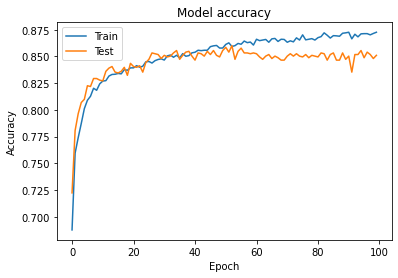

In [370]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

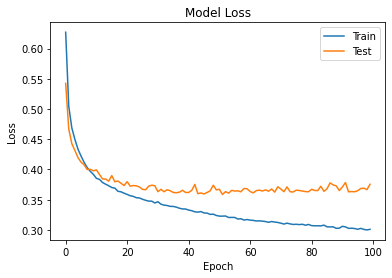

In [372]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

###Tune parameters

In [ ]:
#to do Hyper parameter search using Grid search

### Final Neural Network Model

In [ ]:
# implement with best Hyperparameters and calculate score

In [ ]:
y_pred = Nnw.predict(X_test)
print("Test accuracy",Nnw.score(X_test, y_test))
print("Train accuracy",Nnw.score(X_train, y_train))

classifier.append("NNW")
train_scores.append(Nnw.score(X_train, y_train))
test_scores.append(Nnw.score(X_test, y_test))

# Improvements : Ensemble method with Crossvalidation

In [ ]:
##### Trying to improve with the ensemble of all predictors
from sklearn.ensemble import VotingRegressor

Reg_vote = VotingRegressor(
    estimators=[
        ('rfs', rfs), # Random Forest
        ('svc', svc), # SVC
        ('Nn', Nnw), # Neural Network
          ])
Reg_vote.fit(X_train, y_train)
Reg_vote.score(X_val, y_val)

In [ ]:
scores = cross_val_score(Reg_vote, X_train, y_train, cv=k_fold)
print("Reg: Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))